In [2]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

from os import listdir
from os.path import isfile, join
import json

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

TRAIN_IMAGES_PATH = '/content/drive/MyDrive/BIG DATA 2/Small Set'
MASKS_PATH = '/content/drive/MyDrive/BIG DATA 2/masks'

In [4]:
def getMASKfromJSON(json):
    smallMask = json['mask']
    mask = np.zeros((512,512),dtype='float32')
    for y in range(len(smallMask)):
        for x in range(len(smallMask[0])):
            if x >= 512:
              mask[json['minY']+y,0] = smallMask[y][x]
            elif y >= 512:
              mask[0,json['minX']+x] = smallMask[y][x]
            else:
              mask[json['minY']+y,json['minX']+x] = smallMask[y][x]
    return(mask)

In [5]:
imageFiles = [f for f in listdir(TRAIN_IMAGES_PATH) if isfile(join(TRAIN_IMAGES_PATH, f))]
print(len(imageFiles),"training images.")
images = []
for f in tqdm(imageFiles,total=len(imageFiles)):
  im = cv2.imread(join(TRAIN_IMAGES_PATH,f),cv2.IMREAD_COLOR)
  images.append(cv2.resize(im,(IMG_WIDTH,IMG_HEIGHT)))
masks = []
for f in tqdm(imageFiles,total=len(imageFiles)):
  f = open(join(MASKS_PATH,f[:-3]+'out'))
  json_load = json.load(f)
  m = getMASKfromJSON(json_load)
  masks.append(cv2.resize(m,(IMG_WIDTH,IMG_HEIGHT)).astype(int)) 
train_df = pd.DataFrame({"img":images,"seg":masks})

630 training images.


100%|██████████| 630/630 [02:29<00:00,  4.22it/s]


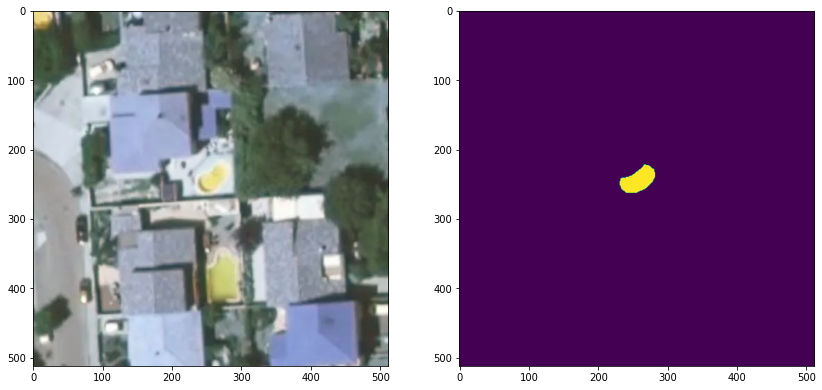

In [6]:
f,axarr = plt.subplots(1,2)
f.set_size_inches(14, 10.5)
axarr[0].imshow(train_df["img"][500])
axarr[1].imshow(train_df["seg"][500])

In [7]:
import cv2
import itertools
import pickle
import seaborn as sns
import tensorflow.keras.losses as ls
import os

from albumentations import CenterCrop, GridDistortion, HorizontalFlip, RandomRotate90, VerticalFlip
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
def normalize_images(image):
  return (image / 127.5 -1)

def image_padding(im):
  h, w = im.shape[0], im.shape[1]
  new_size = max([h, w])
  if len(im.shape)==3:
    pad = np.zeros([new_size, new_size, 3])
    pad[abs(h-new_size)//2: abs(h-new_size)//2 + h, abs(w-new_size)//2: abs(w-new_size)//2 + w, :] = im
  else:
    pad = np.zeros([new_size, new_size])
    pad[abs(h-new_size)//2: abs(h-new_size)//2 + h, abs(w-new_size)//2: abs(w-new_size)//2 + w] = im
  return pad

def resize_xy(df_xy, size=256, pad=False):
  # resize segmentation masks and image while keeping the label values
  orig_shape = []
  img_resized = []
  seg_resized = []
  for i in range(len(df_xy)):
    orig_shape.append(df_xy.loc[i,'img'].shape)
    if pad:
      # pad images before resizing to not distort the proportions
      img = image_padding(df_xy.loc[i,'img'])
      msk = image_padding(df_xy.loc[i,'seg'])
    else:
      img = df_xy.loc[i,'img']
      msk = df_xy.loc[i,'seg']
    img_resized.append(normalize_images(cv2.resize(img, (size, size))))
    seg_resized.append(cv2.resize(msk, (size, size), 0, 0, interpolation = cv2.INTER_NEAREST).astype('float'))
  df_xy['orig_shape'] = orig_shape
  df_xy['img_resized'] = img_resized
  df_xy['seg_resized'] = seg_resized
  return df_xy

def augment_data(imgs, masks, size=512):
  H = size
  W = size
  aug_imgs = []
  aug_masks = []
  for i in range(len(imgs)):
    x = imgs[i]
    y = masks[i]

    aug = CenterCrop(H, W, p=1.0)
    augmented = aug(image=x, mask=y)
    x1 = augmented["image"]
    y1 = augmented["mask"]

    aug = RandomRotate90(p=1.0)
    augmented = aug(image=x, mask=y)
    x2 = augmented['image']
    y2 = augmented['mask']

    aug = GridDistortion(p=1.0)
    augmented = aug(image=x, mask=y)
    x3 = augmented['image']
    y3 = augmented['mask']

    aug = HorizontalFlip(p=1.0)
    augmented = aug(image=x, mask=y)
    x4 = augmented['image']
    y4 = augmented['mask']

    aug = VerticalFlip(p=1.0)
    augmented = aug(image=x, mask=y)
    x5 = augmented['image']
    y5 = augmented['mask']

    aug_imgs.append([x, x1, x2, x3, x4, x5])
    aug_masks.append([y, y1, y2, y3, y4, y5])
  return aug_imgs, aug_masks

In [9]:
def convolution_block(block_input, num_filters=64, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear")(x)
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)
    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)
    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [10]:
def convolution_block(block_input, num_filters=64, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear")(x)
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)
    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)
    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [23]:
class trainDeepLabV3():
  def __init__(self, train_df, image_size=256, batch_size=32, num_classes=21):
    self.model = DeeplabV3Plus(image_size, num_classes)
    self.batch_size = batch_size
    self.loss = ls.SparseCategoricalCrossentropy(from_logits=True)
    self.prepare_data(train_df, image_size)

  def prepare_data(self, train_df, image_size):
    # extract portion from training set as validation set
    validation_set = train_df.sample(frac=.15).reset_index()
    training_set = train_df.drop(validation_set.index).reset_index()
    training_set = resize_xy(training_set, image_size)
    validation_set = resize_xy(validation_set, image_size)
    x_train, y_train = augment_data(training_set['img_resized'].to_list(), training_set['seg_resized'].to_list(), image_size)
    self.x_train = np.array(list(itertools.chain(*x_train)))
    self.y_train = np.expand_dims(list(itertools.chain(*y_train)),-1)
    self.x_val = np.array(validation_set['img_resized'].to_list())
    self.y_val = np.expand_dims(validation_set['seg_resized'].to_list(),-1)

  def warmup(self, batch_size = 32, epochs=10):
    # train layers for few epochs
    for l in self.model.layers:
      l.trainable = True
    self.model.compile(
      optimizer=keras.optimizers.Adam(1e-3),
      loss=self.loss,
      metrics=keras.metrics.sparse_categorical_accuracy,
    )
    # fit model keeping high and constant learning rate for 10 epochs
    print(" ======================= DeepLabV3+ Warm-up =======================")
    self.model.fit(
      x=self.x_train,
      y=self.y_train,
      batch_size=self.batch_size,
      epochs=epochs,
      validation_data=(self.x_val, self.y_val),
      callbacks=keras.callbacks.ReduceLROnPlateau(),
    )

  def train(self, epochs=50):
    # freeze warmed-up layers of ResNet50 backbone
    for l in self.model.layers[:35]:
      l.trainble = False
    self.model.compile(
      optimizer=keras.optimizers.Adam(1e-4),
      loss=self.loss,
      metrics=keras.metrics.sparse_categorical_accuracy,
    )
    # create output directory
    if not os.path.exists('kaggle/DeepLabv3/'):
      os.makedirs('kaggle/DeepLabv3/')
    # train model with a learning rate reduced when a plateau is hit
    callbacks = [
      keras.callbacks.ModelCheckpoint('kaggle/DeepLabv3/deeplabv3.h5', save_weights_only=True, save_best_only=True, mode='min'),
      keras.callbacks.ReduceLROnPlateau(),
    ]
    print(" ======================= DeepLabV3+ Training  =======================")
    history = self.model.fit(
      x=self.x_train,
      y=self.y_train,
      batch_size=self.batch_size,
      epochs=epochs,
      validation_data=(self.x_val, self.y_val),
      callbacks=callbacks,
    )
    # save training history
    with open('kaggle/DeepLabv3/trainHistory_deeplabv3', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    return self.model, history

  def plot_performance(self, hist_path='kaggle/DeepLabv3/trainHistory_deeplabv3'):
    start = 2
    hist = pd.read_pickle(hist_path)
    plt.figure(figsize=(20,10))
    plt.suptitle('prior-training data augmentation', fontsize=20)
    sns.set_style('dark')
    plt.subplot(121)
    plt.plot(hist['sparse_categorical_accuracy'][2:])
    plt.plot(hist['val_sparse_categorical_accuracy'])
    plt.title('DeeplabV3+ accuracy', fontsize=15)
    plt.ylim([0,1])
    plt.ylabel('accuracy', fontsize=12)
    plt.xlabel('epoch', fontsize=12)
    plt.legend(['training', 'validation'], loc='upper left')
    plt.subplot(122)
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title('DeeplabV3+ loss', fontsize=15)
    plt.ylabel('loss', fontsize=12)
    plt.xlabel('epoch', fontsize=12)
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()
    print("He")

In [12]:
#Training with data augmentation on-the-fly
training_set = resize_xy(train_df, 128)
model_ = trainDeepLabV3(training_set, batch_size=32, image_size=128, num_classes=2)
model, hist = model_.train(epochs=100)

94781440/94765736 [==============================] - 0s 0us/step
 ======================= DeepLabV3+ Training  =======================
Epoch 1/100
101/101 [==============================] - 36s 173ms/step - loss: 0.1558 - sparse_categorical_accuracy: 0.9843 - val_loss: 23.7821 - val_sparse_categorical_accuracy: 0.2639 - lr: 1.0000e-04
Epoch 2/100
101/101 [==============================] - 14s 140ms/step - loss: 0.0724 - sparse_categorical_accuracy: 0.9918 - val_loss: 11.1877 - val_sparse_categorical_accuracy: 0.6629 - lr: 1.0000e-04
Epoch 3/100
101/101 [==============================] - 14s 143ms/step - loss: 0.0503 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.5162 - val_sparse_categorical_accuracy: 0.8770 - lr: 1.0000e-04
Epoch 4/100
101/101 [==============================] - 15s 144ms/step - loss: 0.0361 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.2260 - val_sparse_categorical_accuracy: 0.9889 - lr: 1.0000e-04
Epoch 5/100
101/101 [==============================] - 15s 

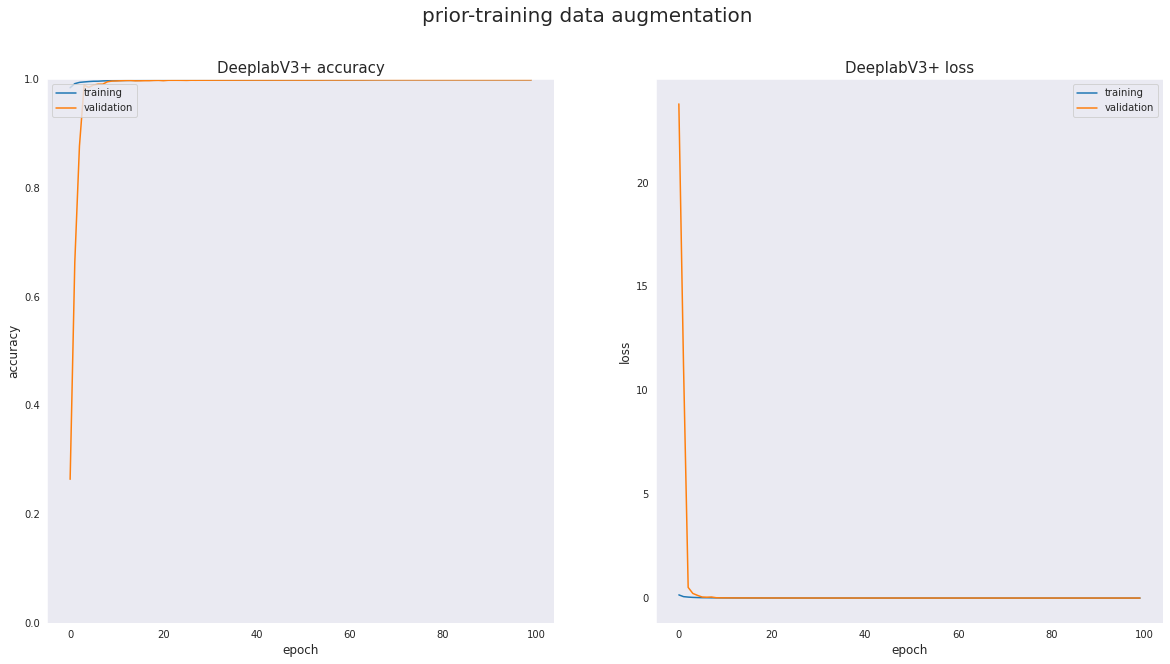

In [24]:
model_.plot_performance()

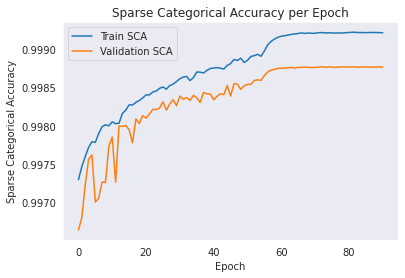

In [41]:
plt.plot(hist.history['sparse_categorical_accuracy'][9:])
plt.plot(hist.history['val_sparse_categorical_accuracy'][9:])
plt.title('Sparse Categorical Accuracy per Epoch')
plt.ylabel('Sparse Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train SCA', 'Validation SCA'], loc='upper left')
plt.show()

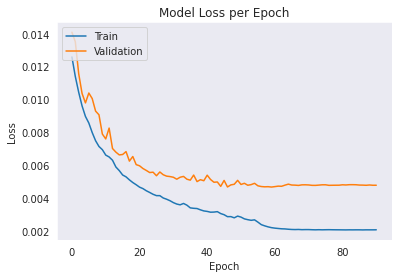

In [42]:
plt.plot(hist.history['loss'][9:])
plt.plot(hist.history['val_loss'][9:])
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
model = DeeplabV3Plus(image_size=128, num_classes=2)
model.load_weights('/content/drive/MyDrive/BIG DATA 2/deeplabv3.h5')

OSError: ignored